In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate, remove_bad_data, chi2_analysis
import pandas as pd
import numpy as np
# from tqdm import tqdm

from scipy import stats
print(pp.__version__)

import matplotlib.pyplot as plt
import ruptures as rpt

from tqdm import tqdm



2.0.1


In [84]:
def create_measurement_unit(df_measurement, net):
    list_value=[]
    list_std=[]
    for index, row in df_measurement.iterrows():
        if row['element_type'] =='bus':
            if row['meas_type'] =='v':
                mu= net.res_bus.iloc[row['element'],0]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='p':
                mu= net.res_bus.iloc[row['element'],2]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='q':
                mu= net.res_bus.iloc[row['element'],3]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
                
        elif row['element_type'] =='line':
            if row['side']=='from':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                    
                    
        elif row['element_type'] =='trafo':
            if row['side']=='from':
                if row['meas_type'] == 'i':
                    mu =net.res_trafo.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'p':
                    mu =net.res_trafo.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'q':
                    mu =net.res_trafo.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='i':
                    mu =net.res_trafo.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='p':
                    mu =net.res_trafo.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='q':
                    mu =net.res_trafo.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
#         print(mu)  
        value = np.random.normal(mu, sigma, 1)
        list_value.append(value[0])
        list_std.append(sigma)
    df_measurement['value']=list_value
    df_measurement['std_dev']=list_std

    for index, row in df_measurement.iterrows():
        if row['element_type']=='bus':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'])
        elif row['element_type']=='line':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'], side=row['side'])
        elif row['element_type']=='trafo':
            if row['meas_type'] in ['p','q']:
                pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                      std_dev=row['std_dev'], element=row['element'], side=row['side'])
    return df_measurement, net

# simple four bus system

In [3]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.9,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0])
scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

In [4]:
scaling_for_solar[0][800:804]=0.1

In [5]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.03
lower_bus_accuracy=0.97
upper_line_accuracy=1.05
lower_line_accuracy=0.95
upper_trafo_accuracy=1.05
lower_trafo_accuracy=0.95

In [7]:
p_mw=np.array([[0,0]])
pv_location=np.random.randint(2, size=2)
# pv_location=[0,0]
print(pv_location)
for scaling_solar, load_scaling in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net = pn.simple_four_bus_system()
    net.sgen.scaling=[scaling_solar*pv_location[0], scaling_solar*pv_location[1]]
    net.load.scaling=[load_scaling, load_scaling]
    pp.runpp(net)
    df_measurement=pd.DataFrame()
    df_measurement['meas_type']=['v','v','p','p','q','q','i','i']
    df_measurement['element_type']=['bus','bus','line','line','line','line','line','line']
    df_measurement['element']=[2,3,0,1,0,1,0,1]
    df_measurement['side']=['None','None','from','from','from','from','from','from']
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="slack", calculate_voltage_angles=True, zero_injection=[1])
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[2:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)

  0%|          | 0/1440 [00:00<?, ?it/s]

[1 0]


100%|██████████| 1440/1440 [06:19<00:00,  4.03it/s]


In [8]:
# find correlation
df=pd.DataFrame()
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
df['bus2']=p_mw[:,0][1:][7*60:-5*60]
df['bus3']=p_mw[:,1][1:][7*60:-5*60]

In [9]:
df['solar_irradiation'].corr(df['bus2'])

-0.8297787500266465

In [10]:
df['solar_irradiation'].corr(df['bus3'])

0.01066378593709394

In [64]:
algo = rpt.Pelt(model='rbf', min_size=20, jump=1).fit(p_mw[1:])
my_bkps = algo.predict(pen=10)

In [65]:
my_bkps

[362, 480, 600, 715, 1020, 1080, 1140, 1320, 1380, 1440]

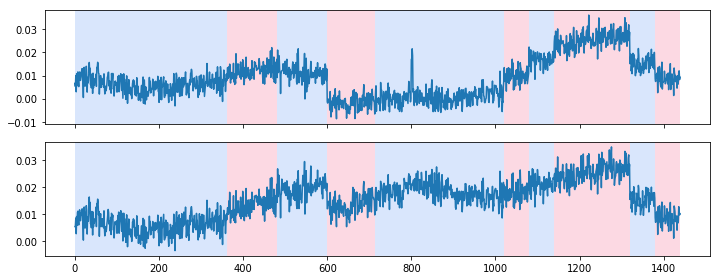

In [66]:
# display
rpt.display(p_mw[1:], my_bkps)
plt.show()

In [82]:
['v']*2+['i']*2

['v', 'v', 'i', 'i']

# CIGRE Task Force C6.04.02 

In [13]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.9,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0])
scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)



In [14]:
# net = pn.create_cigre_network_mv(with_der="pv_wind")
# net.switch.closed=[True]*2+[True]*2+[True]*2+[True]*2
# net.sgen.scaling[:]=0
# pp.runpp(net)

In [91]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.03
lower_bus_accuracy=0.97
upper_line_accuracy=1.05
lower_line_accuracy=0.95
upper_trafo_accuracy=1.03
lower_trafo_accuracy=0.97

In [67]:
list_bus_meas=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
list_line_meas=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
list_transfo_meas[0,1]
df_measurement=pd.DataFrame()
df_measurement['meas_type']=['v']*len(list_bus_meas)+['p','q','i']*len(list_line_meas)+['p','q','i']*len(list_transfo_meas)
df_measurement['element_type']=['bus']*len(list_bus_meas)+['line','line','line']*len(list_line_meas)+['trafo','trafo','trafo']*len(list_transfo_meas)
df_measurement['element']=[item for item in list_bus_meas]+[item for item in list_line_meas for x in range(3)]+[item for item in list_transfo_meas for x in range(3)]
df_measurement['side']=['None']*len(list_bus_meas)+['from','from','from']*len(list_line_meas)+['to','to','to']*len(list_transfo_meas)
p_mw=np.array([np.zeros(15)])
net = pn.create_cigre_network_mv(with_der="pv_wind")
net.load.drop([0,8], axis=0, inplace=True)
net.load.reset_index(drop=True, inplace=True)
net.switch.closed=[True]*2+[True]*2+[True]*2+[True]*2
pv_location=np.random.randint(2, size=9)
print(pv_location)
for scaling_solar, load_scaling in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net.sgen.scaling=scaling_solar*pv_location
    net.load.scaling[:]=load_scaling
    pp.runpp(net)
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="flat")
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)



  0%|          | 0/1440 [00:00<?, ?it/s]

[0 0 1 0 0 0 1 0 0]




  0%|          | 1/1440 [00:00<14:00,  1.71it/s]

  0%|          | 2/1440 [00:01<13:29,  1.78it/s]

  0%|          | 3/1440 [00:01<12:45,  1.88it/s]

  0%|          | 4/1440 [00:02<12:07,  1.97it/s]

  0%|          | 5/1440 [00:02<11:39,  2.05it/s]

  0%|          | 6/1440 [00:02<11:19,  2.11it/s]

  0%|          | 7/1440 [00:03<11:08,  2.14it/s]

  1%|          | 8/1440 [00:03<11:06,  2.15it/s]

  1%|          | 9/1440 [00:04<11:02,  2.16it/s]

  1%|          | 10/1440 [00:04<10:57,  2.17it/s]

  1%|          | 11/1440 [00:05<10:56,  2.18it/s]

  1%|          | 12/1440 [00:05<10:53,  2.19it/s]

  1%|          | 13/1440 [00:06<10:51,  2.19it/s]

  1%|          | 14/1440 [00:06<10:50,  2.19it/s]

  1%|          | 15/1440 [00:06<10:49,  2.19it/s]

  1%|          | 16/1440 [00:07<10:49,  2.19it/s]

  1%|          | 17/1440 [00:07<10:49,  2.19it/s]

  1%|▏         | 18/1440 [00:08<10:47,  2.20it/s]

  1%|▏         | 19/1440 [00:08<10:47,  2.19it/s]

  1%|▏         | 20/1440 [00:09<10:48,

 10%|▉         | 137/1440 [01:02<09:54,  2.19it/s]

 10%|▉         | 138/1440 [01:03<09:53,  2.19it/s]

 10%|▉         | 139/1440 [01:03<09:49,  2.21it/s]

 10%|▉         | 140/1440 [01:04<09:48,  2.21it/s]

 10%|▉         | 141/1440 [01:04<09:46,  2.21it/s]

 10%|▉         | 142/1440 [01:05<09:42,  2.23it/s]

 10%|▉         | 143/1440 [01:05<09:43,  2.22it/s]

 10%|█         | 144/1440 [01:06<09:43,  2.22it/s]

 10%|█         | 145/1440 [01:06<09:40,  2.23it/s]

 10%|█         | 146/1440 [01:06<09:42,  2.22it/s]

 10%|█         | 147/1440 [01:07<09:41,  2.23it/s]

 10%|█         | 148/1440 [01:07<09:39,  2.23it/s]

 10%|█         | 149/1440 [01:08<09:37,  2.23it/s]

 10%|█         | 150/1440 [01:08<09:36,  2.24it/s]

 10%|█         | 151/1440 [01:09<09:34,  2.24it/s]

 11%|█         | 152/1440 [01:09<09:34,  2.24it/s]

 11%|█         | 153/1440 [01:10<09:36,  2.23it/s]

 11%|█         | 154/1440 [01:10<09:36,  2.23it/s]

 11%|█         | 155/1440 [01:10<09:36,  2.23it/s]

 11%|█      

 19%|█▉        | 274/1440 [02:08<08:55,  2.18it/s]

 19%|█▉        | 275/1440 [02:08<08:53,  2.19it/s]

 19%|█▉        | 276/1440 [02:09<08:50,  2.20it/s]

 19%|█▉        | 277/1440 [02:09<08:59,  2.15it/s]

 19%|█▉        | 278/1440 [02:10<09:15,  2.09it/s]

 19%|█▉        | 279/1440 [02:10<09:05,  2.13it/s]

 19%|█▉        | 280/1440 [02:10<09:01,  2.14it/s]

 20%|█▉        | 281/1440 [02:11<09:03,  2.13it/s]

 20%|█▉        | 282/1440 [02:11<09:00,  2.14it/s]

 20%|█▉        | 283/1440 [02:12<08:58,  2.15it/s]

 20%|█▉        | 284/1440 [02:12<08:57,  2.15it/s]

 20%|█▉        | 285/1440 [02:13<08:55,  2.16it/s]

 20%|█▉        | 286/1440 [02:13<09:02,  2.13it/s]

 20%|█▉        | 287/1440 [02:14<09:00,  2.13it/s]

 20%|██        | 288/1440 [02:14<09:22,  2.05it/s]

 20%|██        | 289/1440 [02:15<09:21,  2.05it/s]

 20%|██        | 290/1440 [02:15<09:21,  2.05it/s]

 20%|██        | 291/1440 [02:16<09:18,  2.06it/s]

 20%|██        | 292/1440 [02:16<09:25,  2.03it/s]

 20%|██     

 29%|██▉       | 415/1440 [03:19<10:08,  1.68it/s]

 29%|██▉       | 416/1440 [03:19<10:05,  1.69it/s]

 29%|██▉       | 417/1440 [03:20<09:29,  1.80it/s]

 29%|██▉       | 418/1440 [03:20<09:13,  1.85it/s]

 29%|██▉       | 419/1440 [03:21<10:02,  1.70it/s]

 29%|██▉       | 420/1440 [03:22<10:00,  1.70it/s]

 29%|██▉       | 421/1440 [03:22<11:47,  1.44it/s]

 29%|██▉       | 422/1440 [03:23<12:48,  1.32it/s]

 29%|██▉       | 423/1440 [03:24<12:02,  1.41it/s]

 29%|██▉       | 424/1440 [03:25<11:30,  1.47it/s]

 30%|██▉       | 425/1440 [03:25<12:10,  1.39it/s]

 30%|██▉       | 426/1440 [03:26<11:10,  1.51it/s]

 30%|██▉       | 427/1440 [03:27<11:05,  1.52it/s]

 30%|██▉       | 428/1440 [03:27<10:44,  1.57it/s]

 30%|██▉       | 429/1440 [03:28<10:35,  1.59it/s]

 30%|██▉       | 430/1440 [03:28<10:18,  1.63it/s]

 30%|██▉       | 431/1440 [03:29<10:06,  1.66it/s]

 30%|███       | 432/1440 [03:30<10:15,  1.64it/s]

 30%|███       | 433/1440 [03:30<10:38,  1.58it/s]

 30%|███    

 39%|███▊      | 556/1440 [04:31<06:39,  2.21it/s]

 39%|███▊      | 557/1440 [04:32<06:38,  2.21it/s]

 39%|███▉      | 558/1440 [04:32<06:52,  2.14it/s]

 39%|███▉      | 559/1440 [04:33<06:46,  2.17it/s]

 39%|███▉      | 560/1440 [04:33<06:41,  2.19it/s]

 39%|███▉      | 561/1440 [04:33<06:36,  2.22it/s]

 39%|███▉      | 562/1440 [04:34<06:33,  2.23it/s]

 39%|███▉      | 563/1440 [04:34<06:31,  2.24it/s]

 39%|███▉      | 564/1440 [04:35<06:29,  2.25it/s]

 39%|███▉      | 565/1440 [04:35<06:27,  2.26it/s]

 39%|███▉      | 566/1440 [04:36<06:26,  2.26it/s]

 39%|███▉      | 567/1440 [04:36<06:27,  2.25it/s]

 39%|███▉      | 568/1440 [04:37<06:26,  2.26it/s]

 40%|███▉      | 569/1440 [04:37<06:25,  2.26it/s]

 40%|███▉      | 570/1440 [04:37<06:24,  2.26it/s]

 40%|███▉      | 571/1440 [04:38<06:23,  2.26it/s]

 40%|███▉      | 572/1440 [04:38<06:23,  2.27it/s]

 40%|███▉      | 573/1440 [04:39<06:22,  2.27it/s]

 40%|███▉      | 574/1440 [04:39<06:21,  2.27it/s]

 40%|███▉   

 48%|████▊     | 697/1440 [05:34<05:29,  2.25it/s]

 48%|████▊     | 698/1440 [05:35<05:28,  2.26it/s]

 49%|████▊     | 699/1440 [05:35<05:28,  2.26it/s]

 49%|████▊     | 700/1440 [05:36<05:28,  2.26it/s]

 49%|████▊     | 701/1440 [05:36<05:32,  2.22it/s]

 49%|████▉     | 702/1440 [05:37<05:31,  2.23it/s]

 49%|████▉     | 703/1440 [05:37<05:30,  2.23it/s]

 49%|████▉     | 704/1440 [05:38<05:29,  2.23it/s]

 49%|████▉     | 705/1440 [05:38<05:33,  2.20it/s]

 49%|████▉     | 706/1440 [05:38<05:36,  2.18it/s]

 49%|████▉     | 707/1440 [05:39<05:32,  2.21it/s]

 49%|████▉     | 708/1440 [05:39<05:28,  2.23it/s]

 49%|████▉     | 709/1440 [05:40<05:26,  2.24it/s]

 49%|████▉     | 710/1440 [05:40<05:25,  2.24it/s]

 49%|████▉     | 711/1440 [05:41<05:24,  2.24it/s]

 49%|████▉     | 712/1440 [05:41<05:24,  2.24it/s]

 50%|████▉     | 713/1440 [05:42<05:24,  2.24it/s]

 50%|████▉     | 714/1440 [05:42<05:22,  2.25it/s]

 50%|████▉     | 715/1440 [05:42<05:22,  2.25it/s]

 50%|████▉  

 58%|█████▊    | 838/1440 [06:38<04:30,  2.22it/s]

 58%|█████▊    | 839/1440 [06:39<04:29,  2.23it/s]

 58%|█████▊    | 840/1440 [06:39<04:29,  2.22it/s]

 58%|█████▊    | 841/1440 [06:39<04:29,  2.22it/s]

 58%|█████▊    | 842/1440 [06:40<04:28,  2.23it/s]

 59%|█████▊    | 843/1440 [06:40<04:28,  2.23it/s]

 59%|█████▊    | 844/1440 [06:41<04:27,  2.23it/s]

 59%|█████▊    | 845/1440 [06:41<04:26,  2.23it/s]

 59%|█████▉    | 846/1440 [06:42<04:26,  2.23it/s]

 59%|█████▉    | 847/1440 [06:42<04:25,  2.23it/s]

 59%|█████▉    | 848/1440 [06:43<04:25,  2.23it/s]

 59%|█████▉    | 849/1440 [06:43<04:25,  2.22it/s]

 59%|█████▉    | 850/1440 [06:44<04:25,  2.22it/s]

 59%|█████▉    | 851/1440 [06:44<04:24,  2.23it/s]

 59%|█████▉    | 852/1440 [06:44<04:23,  2.23it/s]

 59%|█████▉    | 853/1440 [06:45<04:23,  2.23it/s]

 59%|█████▉    | 854/1440 [06:45<04:22,  2.23it/s]

 59%|█████▉    | 855/1440 [06:46<04:22,  2.23it/s]

 59%|█████▉    | 856/1440 [06:46<04:21,  2.23it/s]

 60%|█████▉ 

 68%|██████▊   | 979/1440 [07:42<03:27,  2.22it/s]

 68%|██████▊   | 980/1440 [07:42<03:26,  2.23it/s]

 68%|██████▊   | 981/1440 [07:43<03:25,  2.23it/s]

 68%|██████▊   | 982/1440 [07:43<03:25,  2.23it/s]

 68%|██████▊   | 983/1440 [07:44<03:24,  2.24it/s]

 68%|██████▊   | 984/1440 [07:44<03:24,  2.23it/s]

 68%|██████▊   | 985/1440 [07:45<03:23,  2.23it/s]

 68%|██████▊   | 986/1440 [07:45<03:22,  2.24it/s]

 69%|██████▊   | 987/1440 [07:45<03:22,  2.23it/s]

 69%|██████▊   | 988/1440 [07:46<03:22,  2.23it/s]

 69%|██████▊   | 989/1440 [07:46<03:22,  2.23it/s]

 69%|██████▉   | 990/1440 [07:47<03:21,  2.23it/s]

 69%|██████▉   | 991/1440 [07:47<03:21,  2.23it/s]

 69%|██████▉   | 992/1440 [07:48<03:20,  2.24it/s]

 69%|██████▉   | 993/1440 [07:48<03:19,  2.24it/s]

 69%|██████▉   | 994/1440 [07:49<03:19,  2.24it/s]

 69%|██████▉   | 995/1440 [07:49<03:19,  2.24it/s]

 69%|██████▉   | 996/1440 [07:49<03:19,  2.23it/s]

 69%|██████▉   | 997/1440 [07:50<03:18,  2.23it/s]

 69%|██████▉

 78%|███████▊  | 1118/1440 [08:44<02:24,  2.24it/s]

 78%|███████▊  | 1119/1440 [08:45<02:23,  2.24it/s]

 78%|███████▊  | 1120/1440 [08:45<02:22,  2.25it/s]

 78%|███████▊  | 1121/1440 [08:46<02:21,  2.25it/s]

 78%|███████▊  | 1122/1440 [08:46<02:21,  2.24it/s]

 78%|███████▊  | 1123/1440 [08:47<02:21,  2.24it/s]

 78%|███████▊  | 1124/1440 [08:47<02:21,  2.24it/s]

 78%|███████▊  | 1125/1440 [08:48<02:21,  2.23it/s]

 78%|███████▊  | 1126/1440 [08:48<02:20,  2.23it/s]

 78%|███████▊  | 1127/1440 [08:48<02:20,  2.23it/s]

 78%|███████▊  | 1128/1440 [08:49<02:19,  2.23it/s]

 78%|███████▊  | 1129/1440 [08:49<02:19,  2.23it/s]

 78%|███████▊  | 1130/1440 [08:50<02:19,  2.23it/s]

 79%|███████▊  | 1131/1440 [08:50<02:18,  2.23it/s]

 79%|███████▊  | 1132/1440 [08:51<02:18,  2.23it/s]

 79%|███████▊  | 1133/1440 [08:51<02:17,  2.23it/s]

 79%|███████▉  | 1134/1440 [08:52<02:17,  2.22it/s]

 79%|███████▉  | 1135/1440 [08:52<02:20,  2.17it/s]

 79%|███████▉  | 1136/1440 [08:53<02:21,  2.15

 87%|████████▋ | 1256/1440 [09:47<01:23,  2.22it/s]

 87%|████████▋ | 1257/1440 [09:47<01:22,  2.22it/s]

 87%|████████▋ | 1258/1440 [09:48<01:24,  2.15it/s]

 87%|████████▋ | 1259/1440 [09:48<01:23,  2.16it/s]

 88%|████████▊ | 1260/1440 [09:49<01:22,  2.19it/s]

 88%|████████▊ | 1261/1440 [09:49<01:21,  2.20it/s]

 88%|████████▊ | 1262/1440 [09:50<01:20,  2.21it/s]

 88%|████████▊ | 1263/1440 [09:50<01:19,  2.23it/s]

 88%|████████▊ | 1264/1440 [09:51<01:18,  2.24it/s]

 88%|████████▊ | 1265/1440 [09:51<01:17,  2.24it/s]

 88%|████████▊ | 1266/1440 [09:51<01:17,  2.24it/s]

 88%|████████▊ | 1267/1440 [09:52<01:17,  2.24it/s]

 88%|████████▊ | 1268/1440 [09:52<01:16,  2.24it/s]

 88%|████████▊ | 1269/1440 [09:53<01:17,  2.22it/s]

 88%|████████▊ | 1270/1440 [09:53<01:18,  2.16it/s]

 88%|████████▊ | 1271/1440 [09:54<01:17,  2.19it/s]

 88%|████████▊ | 1272/1440 [09:54<01:16,  2.21it/s]

 88%|████████▊ | 1273/1440 [09:55<01:15,  2.22it/s]

 88%|████████▊ | 1274/1440 [09:55<01:14,  2.24

 97%|█████████▋| 1394/1440 [10:49<00:20,  2.21it/s]

 97%|█████████▋| 1395/1440 [10:49<00:20,  2.20it/s]

 97%|█████████▋| 1396/1440 [10:50<00:19,  2.21it/s]

 97%|█████████▋| 1397/1440 [10:50<00:19,  2.22it/s]

 97%|█████████▋| 1398/1440 [10:51<00:18,  2.22it/s]

 97%|█████████▋| 1399/1440 [10:51<00:18,  2.22it/s]

 97%|█████████▋| 1400/1440 [10:52<00:17,  2.23it/s]

 97%|█████████▋| 1401/1440 [10:52<00:17,  2.23it/s]

 97%|█████████▋| 1402/1440 [10:53<00:17,  2.23it/s]

 97%|█████████▋| 1403/1440 [10:53<00:16,  2.22it/s]

 98%|█████████▊| 1404/1440 [10:54<00:16,  2.22it/s]

 98%|█████████▊| 1405/1440 [10:54<00:16,  2.13it/s]

 98%|█████████▊| 1406/1440 [10:54<00:15,  2.17it/s]

 98%|█████████▊| 1407/1440 [10:55<00:15,  2.19it/s]

 98%|█████████▊| 1408/1440 [10:55<00:14,  2.21it/s]

 98%|█████████▊| 1409/1440 [10:56<00:13,  2.22it/s]

 98%|█████████▊| 1410/1440 [10:56<00:13,  2.23it/s]

 98%|█████████▊| 1411/1440 [10:57<00:13,  2.21it/s]

 98%|█████████▊| 1412/1440 [10:57<00:12,  2.21

In [71]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service
0,Trafo 0-1,None,0,1,25.0,110.0,20.0,12.00107,0.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1.0,True
1,Trafo 0-12,None,0,12,25.0,110.0,20.0,12.00107,0.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1.0,True


In [102]:
df=pd.DataFrame()
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
for bus in range(0,len(p_mw[0])):
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))

ValueError: Length of values does not match length of index

In [100]:
p_mw

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [101]:
algo = rpt.Pelt(model='rbf', min_size=100, jump=1).fit(p_mw[1:])
my_bkps = algo.predict(pen=1)

/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


ValueError: min() arg is an empty sequence

In [59]:
my_bkps

NameError: name 'my_bkps' is not defined

In [60]:
# display
rpt.display(p_mw[1:], my_bkps)
plt.show()

NameError: name 'my_bkps' is not defined

In [62]:
pv_location=np.random.randint(2, size=9)



In [65]:
scaling_solar*pv_location

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [64]:
scaling_solar

0.0

In [141]:
list_bus_meas=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
list_line_meas=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
list_trafo_meas=[0,1]
df_measurement=pd.DataFrame()
df_measurement['meas_type']=['v']*len(list_bus_meas)+['p','q','i']*len(list_line_meas)+['p','q','i']*len(list_trafo_meas)
df_measurement['element_type']=['bus']*len(list_bus_meas)+['line','line','line']*len(list_line_meas)+['trafo','trafo','trafo']*len(list_trafo_meas)
df_measurement['element']=[item for item in list_bus_meas]+[item for item in list_line_meas for x in range(3)]+[item for item in list_trafo_meas for x in range(3)]
df_measurement['side']=['None']*len(list_bus_meas)+['from','from','from']*len(list_line_meas)+['to','to','to']*len(list_trafo_meas)
p_mw=np.array([np.zeros(15)])

net = pn.create_cigre_network_mv(with_der="pv_wind")
net.load.drop([0,8], axis=0, inplace=True)
net.load.reset_index(drop=True, inplace=True)
net.switch.closed=[True]*2+[True]*2+[True]*2+[True]*2    
pp.runpp(net)
df_measurement, net = create_measurement_unit(df_measurement, net)
success = estimate(net, init="flat")

,vm_pu,va_degree,p_mw,q_mvar
0,-0.028543,0.000000,-17.034226,9.858468
1,-0.007122,27.737683,8.656168,-4.776237
2,-0.007096,27.737325,0.051817,-0.012172
3,-0.006865,27.763715,-0.084794,-0.002120
4,-0.006887,27.762329,0.015778,-0.005143
5,-0.006895,27.762872,0.009386,0.007673
6,-0.006864,27.766254,-0.041444,-0.001852
7,-0.006871,27.765935,0.023436,0.001613
8,-0.006885,27.764073,0.035413,0.013141
9,-0.006881,27.763231,-0.004658,-0.016768
